# Notebook de modelisation

### Chris Hozé

#### On utilise tensorflow donc on se place dans l'environnement tensor_env paramétré avec tensor_gpu


In [52]:
# Import des 

# Import des packages 
import pandas as pd
import numpy as np
import pathlib
import os
#from scipy import sparse

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

# Keras et tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# # sklearn
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import KFold, train_test_split   
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# On vérifie que la gpu fonctionne

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# En repartant du dataset tabulaire : c'est possible mais pas ideal car il est long à créer
Cela pourrait tout de même être intéressant pour pouvoir utiliser l info URL

In [ ]:
# Charger le dataset tabulaire préprocessé ne fonctionne pas pour utilisation de tensorflow

# file = r"C:\Users\Inrae\Documents\Projet_Data_Science\radio_tab.csv"

# # Dataset complet mais reduit en 100*100

# df = pd.read_csv(file)
# # On cree un jeu de données réduit en respectant les proportions initiales 

# df.rename(columns = {'Unnamed: 0':'FILENAME'}, inplace = True)

# df = df.set_index("FILENAME")

# #df = df.rename(columns = {'Unnamed : 0' : 'FILENAME'})
# df.head()


# On recode la variable source

#cat_url = pd.get_dummies(df["URL"], prefix="url")

#df = pd.concat([cat_url, df], axis=1)

#X = df.drop(["URL","SIZE","FORMAT","TYPE","num"], axis=1)

#X.head()


# En repartant du notebook de MME pour l'import des données
## Preprocessing et export des données masquées

In [21]:

# # On recrée un répertoire de données préprocessées, redimensionnées en 224*224 avec filtre gaussien et masquage

# path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
# data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")
# output_path = os.path.join(path_to_data,"processed")
# folder_to_process = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# make_tiny=False
# tiny_size=1000
# final_size=(224,224)

# for img_type in  folder_to_process:
#     print(f"Processing folder: {img_type}")

#     img_folder_path = os.path.join(data_folder_path,img_type,"images")
#     mask_folder_path = os.path.join(data_folder_path,img_type,"masks")

#     output_folder_path = os.path.join(output_path, img_type)
#     #output_folder_path.mkdir(parents=True, exist_ok=True)

#     nb_image_done = 0
#     for image_name, mask_name in zip(os.listdir(img_folder_path),
#                                      os.listdir(mask_folder_path)):

#         image_path = os.path.join(img_folder_path, image_name)
#         mask_path = os.path.join(mask_folder_path, mask_name)

#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         # resized to mask size
#         image = cv2.resize(image, dsize = (256, 256)) # fixed size to mask size

#         # masking
#         res =  cv2.bitwise_and(image, image, mask=mask)
#         res = cv2.GaussianBlur(res, ksize = (3,3), sigmaX=0.2)
#         res = cv2.resize(res, dsize = final_size)

#         # Write masked image
#         output_image_name = image_name + '_masked.png'
#         output_file =  os.path.join(output_folder_path, output_image_name)
#         cv2.imwrite(output_file, res)

#         nb_image_done += 1
#         if make_tiny and nb_image_done >= tiny_size:
#             break

#     print(f"Processing folder: {img_type} done.")


## On importe les images préprocessées et masquées

In [5]:

path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")
output_path = os.path.join(path_to_data,"processed")
final_size=(224,224)

# Import des données on sépare entre apprentissage et validation
batch_size=32
data_dir=output_path
size=final_size

# On laisse en couleur pour pouvoir utiliser les modeles preentrainés

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    #color_mode= "grayscale",
    seed=42,
    image_size=size,
    batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="validation",
    #color_mode= "grayscale",
    seed=42,
    image_size=size,
    batch_size=batch_size)



Found 21165 files belonging to 4 classes.
Using 10583 files for training.
Found 21165 files belonging to 4 classes.
Using 10582 files for validation.


In [6]:
# Création X_train, X_test, y_train, y_test

# For train data
all_images = []
all_labels = []

for images, labels in train_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_train = np.concatenate(all_images)
y_train = np.concatenate(all_labels)

# For test data
all_images = []
all_labels = []

for images, labels in val_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images)
y_test = np.concatenate(all_labels)

# normalization
X_train = X_train / 255
X_test = X_test / 255

# encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [7]:
# On cree un generateur d image

train_datagen = ImageDataGenerator(
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    #horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    #width_shift_range=0.1,
    #height_shift_range=0.1  
    ) 

test_datagen = ImageDataGenerator()

# Augmenter respectivement les jeu de données d'entrainement
train_dataset = train_datagen.flow(X_train,y_train,   batch_size = 64)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 64)



# Modèle de DL
## Test d un premier modèle from scratch

In [14]:
# Construction d un modèle classique

model = Sequential()

# Couche d'entrée pour les images 224x224 avec 3 canaux (RGB) 
model.add(Input(shape=(224, 224, 3))) 

# Première couche de convolution 
model.add(Conv2D(16, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2))) 

# Deuxième couche de convolution 
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2))) 

# Troisième couche de convolution 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2)))

# Quatireme couche de convolution 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2)))


# Couche flatten pour transformer les cartes de caractéristiques en un vecteur 
model.add(Flatten()) 

# Ajouter des couches fully connected (denses) 

model.add(Dense(60, activation='relu')) 
model.add(Dense(4, activation='softmax')) 

#Compiler le modèle model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir le learning rate désiré 
learning_rate = 0.001 #

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

#Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks 

batch_size = 64
epochs = 10 
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            verbose=True)

Epoch 1/10
165/165 [==============================] - 81s 484ms/step - loss: 1.8190 - accuracy: 0.6308 - val_loss: 1.3669 - val_accuracy: 0.4838
Epoch 2/10
165/165 [==============================] - 81s 493ms/step - loss: 0.6717 - accuracy: 0.7338 - val_loss: 1.3680 - val_accuracy: 0.4838
Epoch 3/10
165/165 [==============================] - 85s 516ms/step - loss: 0.6413 - accuracy: 0.7498 - val_loss: 1.3635 - val_accuracy: 0.4838
Epoch 4/10
165/165 [==============================] - 86s 519ms/step - loss: 0.6013 - accuracy: 0.7693 - val_loss: 1.3633 - val_accuracy: 0.4838
Epoch 5/10
165/165 [==============================] - 84s 508ms/step - loss: 0.5782 - accuracy: 0.7716 - val_loss: 1.3617 - val_accuracy: 0.4838
Epoch 6/10
165/165 [==============================] - 85s 516ms/step - loss: 0.5632 - accuracy: 0.7790 - val_loss: 1.3595 - val_accuracy: 0.4838
Epoch 7/10
165/165 [==============================] - 92s 556ms/step - loss: 0.5378 - accuracy: 0.7902 - val_loss: 1.3574 - val_ac

## On fait un modele avec RESNET préentrainé sur image net

In [65]:
# On importe un modele préentrainé : REsnet50
# https://keras.io/api/applications/#finetune-inceptionv3-on-a-new-set-of-classes
#import h5py

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = ResNet50(weights='imagenet')

#base_model.summary()


len(base_model.layers)



177

In [11]:

# add a global spatial average pooling layer
x = base_model.output

#x = MaxPooling4D(4,4)(x)

# Couche flatten pour transformer les cartes de caractéristiques en un vecteur 
x = Flatten()(x)

# Ajouter des couches fully connected (denses) 

x = Dense(60, activation='relu')(x) 

predictions = Dense(4, activation='softmax')(x) 

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first:  freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='Adam', loss='categorical_crossentropy',   metrics = ["accuracy"])

# train the model on the new data for a few epochs
model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = 10,
            verbose=True)



Epoch 1/10
165/165 [==============================] - 132s 778ms/step - loss: 1.1584 - accuracy: 0.5164 - val_loss: 1.3760 - val_accuracy: 0.2801
Epoch 2/10
165/165 [==============================] - 139s 840ms/step - loss: 0.9659 - accuracy: 0.6235 - val_loss: 1.9295 - val_accuracy: 0.2801
Epoch 3/10
165/165 [==============================] - 142s 858ms/step - loss: 0.8832 - accuracy: 0.6486 - val_loss: 2.3660 - val_accuracy: 0.2801
Epoch 4/10
165/165 [==============================] - 142s 863ms/step - loss: 0.8462 - accuracy: 0.6653 - val_loss: 2.5808 - val_accuracy: 0.2801
Epoch 5/10
165/165 [==============================] - 147s 889ms/step - loss: 0.8135 - accuracy: 0.6805 - val_loss: 2.7803 - val_accuracy: 0.2801
Epoch 6/10
165/165 [==============================] - 149s 902ms/step - loss: 0.7964 - accuracy: 0.6886 - val_loss: 2.8758 - val_accuracy: 0.2801
Epoch 7/10
165/165 [==============================] - 139s 843ms/step - loss: 0.7870 - accuracy: 0.6936 - val_loss: 2.9264 -

On degele les parametres des 10 dernieres couches

In [15]:
# ## Vu la precision on unfreeze certaine couche

# add a global spatial average pooling layer
x = base_model.output

#x = MaxPooling4D(4,4)(x)

# Couche flatten pour transformer les cartes de caractéristiques en un vecteur 
x = Flatten()(x)

# Ajouter des couches fully connected (denses) 

x = Dense(60, activation='relu')(x) 

predictions = Dense(4, activation='softmax')(x) 


# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:165]:
   layer.trainable = False
for layer in model.layers[165:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from tenkeras.optimizers import SGD
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Définir le learning rate désiré 
learning_rate = 0.0001 #

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = 10,
            verbose=True)


Epoch 1/10
165/165 [==============================] - 80s 481ms/step - loss: 0.4531 - accuracy: 0.8238 - val_loss: 1.3551 - val_accuracy: 0.2765
Epoch 2/10
165/165 [==============================] - 80s 485ms/step - loss: 0.4581 - accuracy: 0.8179 - val_loss: 1.3551 - val_accuracy: 0.2765
Epoch 3/10
165/165 [==============================] - 88s 532ms/step - loss: 0.4599 - accuracy: 0.8196 - val_loss: 1.3551 - val_accuracy: 0.2765
Epoch 4/10
165/165 [==============================] - 83s 503ms/step - loss: 0.4587 - accuracy: 0.8194 - val_loss: 1.3551 - val_accuracy: 0.2765
Epoch 5/10
165/165 [==============================] - 91s 550ms/step - loss: 0.4555 - accuracy: 0.8216 - val_loss: 1.3551 - val_accuracy: 0.2765
Epoch 6/10
165/165 [==============================] - 91s 551ms/step - loss: 0.4578 - accuracy: 0.8202 - val_loss: 1.3551 - val_accuracy: 0.2765
Epoch 7/10
165/165 [==============================] - 98s 595ms/step - loss: 0.4561 - accuracy: 0.8190 - val_loss: 1.3551 - val_ac

#### En reprocessant les données, attention à s'assurer que training et validation sont bien distincts

In [66]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.6 # Pourcentage de données d'entraînement 
validation_ratio = 0.4 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
  
# Pas ideal car on applique un image generator sur le jeu de validation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers[:165]:
   layer.trainable = False
for layer in model.layers[165:]:
   layer.trainable = True

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 10,
            verbose=True)

Found 12701 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 180s 894ms/step - loss: 0.9581 - accuracy: 0.6767 - val_loss: 0.9540 - val_accuracy: 0.6254
Epoch 2/10
198/198 [==============================] - 188s 949ms/step - loss: 0.6351 - accuracy: 0.7715 - val_loss: 0.6630 - val_accuracy: 0.7559
Epoch 3/10
198/198 [==============================] - 186s 937ms/step - loss: 0.5763 - accuracy: 0.7827 - val_loss: 0.5218 - val_accuracy: 0.8192
Epoch 4/10
198/198 [==============================] - 188s 950ms/step - loss: 0.5307 - accuracy: 0.8016 - val_loss: 0.6772 - val_accuracy: 0.7535
Epoch 5/10
198/198 [==============================] - 188s 948ms/step - loss: 0.5027 - accuracy: 0.8185 - val_loss: 0.6458 - val_accuracy: 0.7292
Epoch 6/10
198/198 [==============================] - 191s 963ms/step - loss: 0.4635 - accuracy: 0.8313 - val_loss: 0.5319 - val_accuracy: 0.8190
Epoch 7/10
198/198 [===================

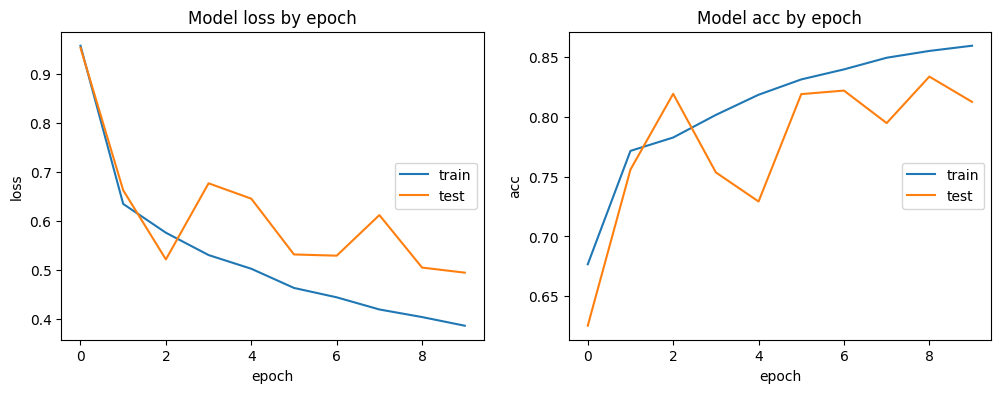

In [68]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


Found 8464 images belonging to 4 classes.
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.75      0.65      1446
           1       0.90      0.62      0.73      2404
           2       0.87      0.94      0.90      4076
           3       0.91      0.85      0.88       538

    accuracy                           0.81      8464
   macro avg       0.82      0.79      0.79      8464
weighted avg       0.83      0.81      0.81      8464



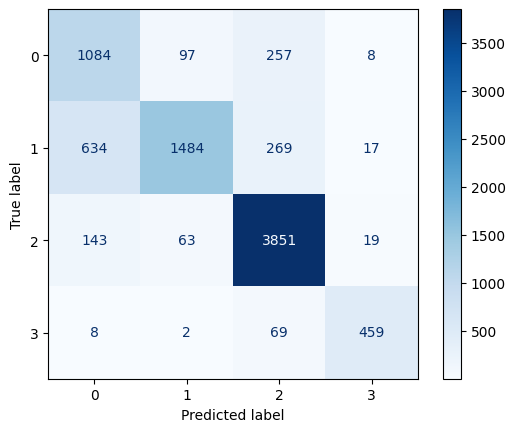

In [71]:

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred))

On recommence sans data augmentation pour s'en assurer.

In [20]:
# On essaye sans data augmentation
# Définir les paramètres pour la séparation des données 
train_ratio = 0.6 # Pourcentage de données d'entraînement 
validation_ratio = 0.4 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation avec moins d augmentation de données
  

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
   #  shear_range = 0.1, # random application of shearing
   #  zoom_range = 0.1,
   #  fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

# test_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     validation_split=validation_ratio,
#     ) 

# Augmenter respectivement les jeu de données d'entrainement

train_dataset = datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle

base_model = ResNet50(weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers[:165]:
   layer.trainable = False
for layer in model.layers[165:]:
   layer.trainable = True


#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = 10,
            verbose=True)


Found 12701 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 120s 584ms/step - loss: 0.9248 - accuracy: 0.7131 - val_loss: 1.1939 - val_accuracy: 0.4232
Epoch 2/10
198/198 [==============================] - 105s 529ms/step - loss: 0.6061 - accuracy: 0.8014 - val_loss: 0.6913 - val_accuracy: 0.7755
Epoch 3/10
198/198 [==============================] - 103s 518ms/step - loss: 0.5238 - accuracy: 0.8200 - val_loss: 0.4905 - val_accuracy: 0.8357
Epoch 4/10
198/198 [==============================] - 101s 508ms/step - loss: 0.4545 - accuracy: 0.8440 - val_loss: 0.6659 - val_accuracy: 0.7448
Epoch 5/10
198/198 [==============================] - 100s 507ms/step - loss: 0.4068 - accuracy: 0.8595 - val_loss: 0.5203 - val_accuracy: 0.8349
Epoch 6/10
198/198 [==============================] - 104s 524ms/step - loss: 0.3673 - accuracy: 0.8757 - val_loss: 0.5588 - val_accuracy: 0.8220
Epoch 7/10
198/198 [===================

## On essaye avec efficientnet B2

In [88]:
# pour refaire de la place sur la gpu
del model
import gc
gc.collect()
tf.keras.backend.clear_session()


In [73]:

from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

base_model = EfficientNetB2(weights='imagenet')

#base_model.summary()


len(base_model.layers)

342

In [74]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.6 # Pourcentage de données d'entraînement 
validation_ratio = 0.4 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

x = base_model.output
x = Flatten()(x)
#x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers[:330]:
   layer.trainable = False
for layer in model.layers[330:]:
   layer.trainable = True

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 10,
            verbose=True)

Found 12701 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 196s 957ms/step - loss: 1.2271 - accuracy: 0.6580 - val_loss: 1.1199 - val_accuracy: 0.6700
Epoch 2/10
198/198 [==============================] - 194s 980ms/step - loss: 1.0321 - accuracy: 0.6763 - val_loss: 0.9625 - val_accuracy: 0.6988
Epoch 3/10
198/198 [==============================] - 183s 924ms/step - loss: 0.9113 - accuracy: 0.7116 - val_loss: 0.8591 - val_accuracy: 0.7353
Epoch 4/10
198/198 [==============================] - 184s 928ms/step - loss: 0.8244 - accuracy: 0.7279 - val_loss: 0.7890 - val_accuracy: 0.7306
Epoch 5/10
198/198 [==============================] - 187s 945ms/step - loss: 0.7636 - accuracy: 0.7618 - val_loss: 0.6907 - val_accuracy: 0.8123
Epoch 6/10
198/198 [==============================] - 183s 922ms/step - loss: 0.7109 - accuracy: 0.7833 - val_loss: 0.6363 - val_accuracy: 0.8321
Epoch 7/10
198/198 [===================

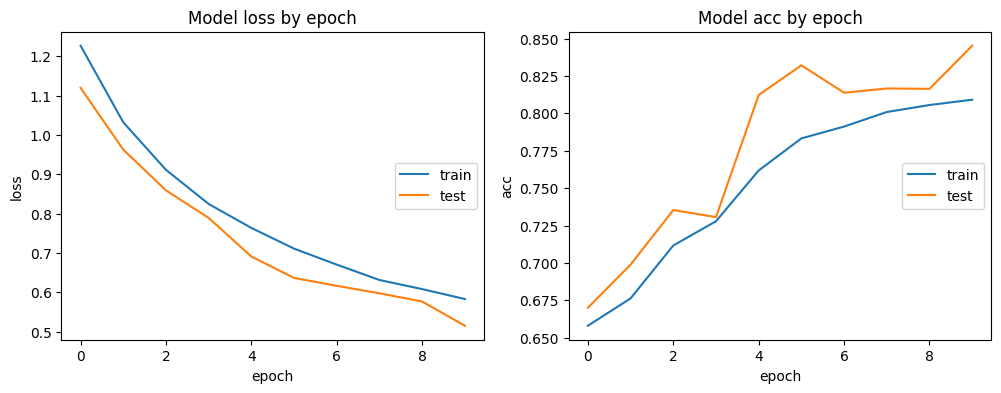

In [77]:
# On trace l evolution de la loss

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 8464 images belonging to 4 classes.
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      1446
           1       0.83      0.83      0.83      2404
           2       0.87      0.93      0.90      4076
           3       0.88      0.89      0.89       538

    accuracy                           0.85      8464
   macro avg       0.84      0.82      0.82      8464
weighted avg       0.84      0.85      0.84      8464



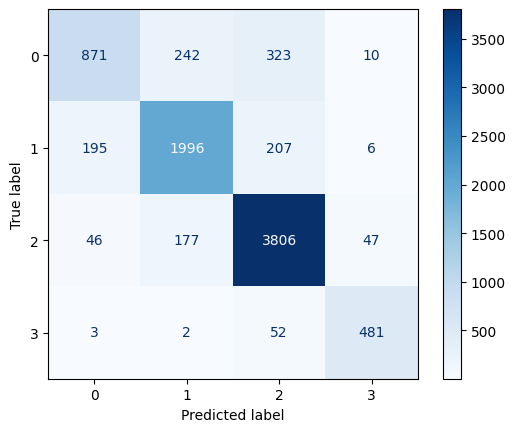

In [78]:
# On fait la matrice de confusion et le rapport de classification

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred))

## Inception V3

In [89]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

base_model = InceptionV3(weights='imagenet', include_top=True)

#base_model.summary()


len(base_model.layers)

313

In [91]:
# Définir les paramètres pour la séparation des données 
train_ratio = 0.6 # Pourcentage de données d'entraînement 
validation_ratio = 0.4 # Pourcentage de données de validation

# On reprocesse les jeux de données d'entrainement et de validation
 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.1, # random application of shearing
    zoom_range = 0.1,
    horizontal_flip = False,
    brightness_range = (0.4, 0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=validation_ratio,
    ) 

test_datagen = ImageDataGenerator(
     preprocessing_function=preprocess_input,
     validation_split=validation_ratio,
     ) 

# Est-on sur dans ce cas que la validation est bien indépendante de l'apprentissage ?

train_dataset = train_datagen.flow_from_directory(data_dir,batch_size = 64, class_mode="categorical", target_size=(224,224), subset='training', seed=42)

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42)

learning_rate = 0.001 #

# On recrée le modèle de zéro car sinon les poids s ajustent au fur et à mesure

x = base_model.output
x = Flatten()(x)
#x = Dense(60, activation='relu')(x) 
predictions = Dense(4, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# on degele les dix dernieres couches:
for layer in model.layers[:300]:
   layer.trainable = False
for layer in model.layers[300:]:
   layer.trainable = True

#Créer une instance de l'optimiseur Adam avec le learning rate personnalisé  
optimizer = Adam(learning_rate=learning_rate) 

# Compiler le modèle avec l'optimiseur personnalisé 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# # train the model on the new data for a few epochs
history = model.fit(train_dataset, # use augmented images for train 
            steps_per_epoch=train_dataset.n // batch_size,
            validation_data = test_dataset, # use initial images for test
            epochs = 10,
            verbose=True)

Found 12701 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.
Epoch 1/10
198/198 [==============================] - 155s 767ms/step - loss: 1.2273 - accuracy: 0.6439 - val_loss: 1.0906 - val_accuracy: 0.6928
Epoch 2/10
198/198 [==============================] - 168s 846ms/step - loss: 1.0087 - accuracy: 0.7131 - val_loss: 0.9356 - val_accuracy: 0.7150
Epoch 3/10
198/198 [==============================] - 168s 846ms/step - loss: 0.8743 - accuracy: 0.7431 - val_loss: 0.8188 - val_accuracy: 0.7780
Epoch 4/10
198/198 [==============================] - 177s 891ms/step - loss: 0.7957 - accuracy: 0.7757 - val_loss: 0.7525 - val_accuracy: 0.7850
Epoch 5/10
198/198 [==============================] - 176s 887ms/step - loss: 0.7419 - accuracy: 0.7806 - val_loss: 0.6944 - val_accuracy: 0.7968
Epoch 6/10
198/198 [==============================] - 176s 887ms/step - loss: 0.7044 - accuracy: 0.7841 - val_loss: 0.6716 - val_accuracy: 0.7995
Epoch 7/10
198/198 [===================

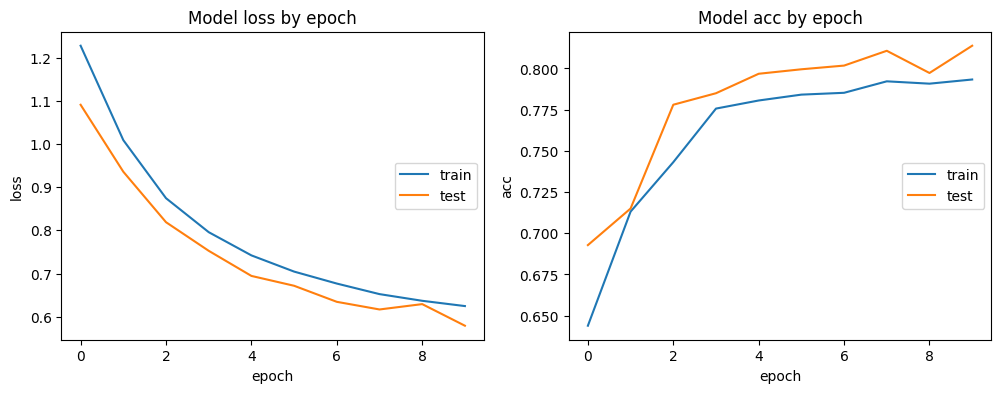

In [92]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Found 8464 images belonging to 4 classes.
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      1446
           1       0.85      0.73      0.79      2404
           2       0.84      0.94      0.88      4076
           3       0.83      0.85      0.84       538

    accuracy                           0.81      8464
   macro avg       0.80      0.78      0.78      8464
weighted avg       0.81      0.81      0.81      8464



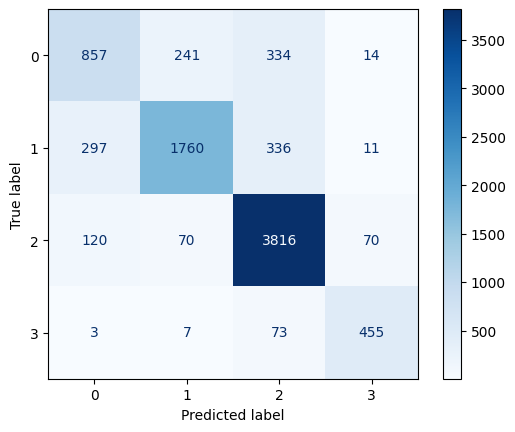

In [93]:

test_dataset = test_datagen.flow_from_directory(data_dir, batch_size = 64, class_mode= "categorical", target_size=(224,224), subset='validation', seed=42, shuffle=False)

Y_pred = model.predict(test_dataset, test_dataset.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_dataset.classes, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred))